# imports

In [ ]:
import cv2                                      # for image operations
import matplotlib.pyplot as plt                 # for visualisation
import numpy as np                              # for numerical operations
from google.colab.patches import cv2_imshow     # for displaying images on colab
from tqdm import tqdm
import random
import os
import IPython.display as Disp
from ipywidgets import widgets

# helper

In [ ]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

# Get the images

In [ ]:
import gdown

images = {
    "https://drive.google.com/file/d/1UPmjo_BEL6FkJiYOZFd_nKMnVjk5MmGP/view?usp=drive_link": "chessboard_imgs.zip",
    "https://drive.google.com/file/d/1gBVAFj2b03-45ULtgt2YFv0sy3oRPpGp/view?usp=drive_link": "harry_potter.jpg"
    }

for url, file_name in images.items():
    gdown.download(url, file_name, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1UPmjo_BEL6FkJiYOZFd_nKMnVjk5MmGP
To: /content/chessboard_imgs.zip
100%|██████████| 365k/365k [00:00<00:00, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gBVAFj2b03-45ULtgt2YFv0sy3oRPpGp
To: /content/harry_potter.jpg
100%|██████████| 2.82M/2.82M [00:00<00:00, 141MB/s]


In [ ]:
!unzip chessboard_imgs.zip

# Camera Calibration

## ***Exercise 1.1*** - Assume you have 2 lists of coordinates *(in a format of `(x,y,z)` and `(x,y)`)*, one contains the coordinates of an object (the world coordinates) and the other contains corresponding coordinates of the image. Try to find the camera matrix. Decompose the matrix into intrinsic and extrinsic matrices.

PS. You can use [`decomposeProjectionMatrix`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248) to decompose the camera matrix.

***The story behind the problem:*** We are working on the object in the image below. Simply put, we actually took the coordinates of the red marked points on the image. Then, we created a coordinate system in the real world by assuming the left corner of the object as the origin. We obtained the coordinates in the real-world by taking the measurements of the edges of the object.

![q3-coordinate_system_and_corners](https://github.com/d2l-ai/d2l-en/assets/52993055/d9abea9e-25b7-4484-80c9-577e86644d4b)




If we consider camera as a coordinate transform:

$ x = PX $

* `x` : homogenous image coordinates (3x1)
* `P` : camera matrix (3x4)
* `X`: homogenous world coordinates (4X1)

In [ ]:
image_coords = np.array([[203.71805397727303, 927.3836203835222],
                        [1718.7725994318184, 669.0563476562493],
                        [2926.627144886363, 2449.4199840198858],
                        [2682.263508522727, 2728.692711292613],
                        [804.1544176136363, 3412.910893110795],
                        [748.2998721590911, 3231.3836203835217]], np.float32)

world_coords = np.array([[0, 19.5, 0],
                        [13.7, 19.5, 0],
                        [13.7, 0, 0],
                        [13.7, 0, -4],
                        [0, 0, -4],
                        [0, 0, 0]], np.float32)

In [ ]:
# adding additional row which equals to 1 for each point in order to create 4X1 homogeneous coordinates
world_coords = np.hstack((world_coords, np.ones((6, 1))))
world_coords

array([[ 0.        , 19.5       ,  0.        ,  1.        ],
       [13.69999981, 19.5       ,  0.        ,  1.        ],
       [13.69999981,  0.        ,  0.        ,  1.        ],
       [13.69999981,  0.        , -4.        ,  1.        ],
       [ 0.        ,  0.        , -4.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
# For each corresponding pair of image and world coordinates, construct rows of a matrix A,
# which will be used for solving a linear system. These rows are based on the equations of a camera
# projection model.

zero4 = np.array((0,0,0,0))

for i in range(0,6):
    # note: since I already have X matrixes in transposed form, I didn't need to apply transpoze
    x_Xn = np.hstack((world_coords[i], zero4, -image_coords[i][0]*world_coords[i])) # X^T   0    -x'X^T
    y_Xn = np.hstack((zero4, -world_coords[i], image_coords[i][1]*world_coords[i])) # 0    X^T   -y'X^T

    if i == 0:
        A = np.vstack((x_Xn, y_Xn)) # creating first two rows of the matrix

    else:
        A = np.vstack((A, x_Xn, y_Xn)) # adding rows to the matrix for other points as well

In [ ]:
# Decompose the constructed matrix A using Singular Value Decomposition (SVD).

u, e, vtranspose = np.linalg.svd(A)     # singular value decomposition

# From the SVD result, extract the column of the matrix v that corresponds to
# the smallest singular value. This column represents the parameters of the camera projection matrix.
# The extracted parameters are reshaped into a 3x4 matrix, representing the camera projection matrix P.

v = np.transpose(vtranspose)            # transpose of V^T

# selects the column of matrix v that corresponds to the index of the smallest singular value.
# Essentially, it selects the singular vector that corresponds to the smallest singular value.
p = v[:, np.argmin(e)]                  # column of V corresponding to smallest singular value of A

P = p.reshape((3,4))

In [ ]:
P # camera projection matrix

array([[ 6.07376568e-02, -6.48021051e-03, -1.60138134e-02,
         2.24409910e-01],
       [-6.16380704e-03, -2.68523850e-02, -6.33416325e-02,
         9.69990411e-01],
       [ 4.38250609e-06,  9.25154261e-06, -1.43039334e-05,
         3.00742557e-04]])

In [ ]:
# Decompose the camera projection matrix into intrinsic matrix K, rotation matrix r,
# and translation vector t using the decomposeProjectionMatrix function

K, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(P) # decomposition of camera matrix

In [ ]:
K # intrintics (3X3)

array([[ 5.80822759e-02, -1.23985669e-03,  2.47468652e-02],
       [ 0.00000000e+00,  5.90421073e-02,  3.58501097e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.75897546e-05]])

In [ ]:
r # 3D rotation (3X3)

array([[ 0.93410429, -0.35218921,  0.05840521],
       [-0.25568005, -0.77416185, -0.57905127],
       [ 0.24915089,  0.52596123, -0.81319566]])

In [ ]:
t # 3D translation (4X1)

array([[-0.01957311],
       [ 0.296363  ],
       [-0.95333678],
       [-0.05417425]])

In [ ]:
# Normalize the translation vector t and convert to homogeneous coordinates by
# dividing by its last element and then removing the last element

t = t / t[-1]
t = t[:-1]

In [ ]:
t # 3D translation (3X1)

array([[ 0.36129919],
       [-5.47055131],
       [17.5976011 ]])

## ***Exercise 1.2*** - Step by step camera calibration

* Read the image named `left01.jpg` and visualize it.

(480, 640, 3)
(480, 640, 3) (480, 640)


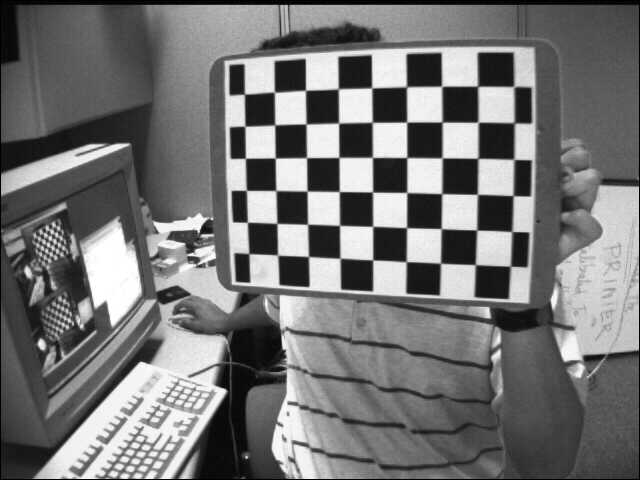

In [ ]:
img_folder = "chessboard_imgs"
images = os.listdir(img_folder)

img = cv2.imread(f"{img_folder}/left01.jpg") # Extract the first image as img
print(img.shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to a gray scale image
print(img.shape, gray.shape)

cv2_imshow(gray); # Visualize gray

* Use the [`findChessboardCorners`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) function to extract the corners from the image gray.

    * Assume a pattern of size (9,6) *(corresponding to the interior corners to locate in the chessboard)*. *(width, height)*
    * Assign the output array of corner coordinates to the identifier `corners`.

* Use NumPy's squeeze function to eliminate singleton dimensions from the array corners.

In [ ]:
retval, corners = cv2.findChessboardCorners(image=gray, patternSize=(9, 6))
print(corners.shape)

corners = np.squeeze(corners) # Get rid of extraneous singleton dimension
print(corners.shape)

print(corners[:5])  # Examine the first few rows of corners

(54, 1, 2)
(54, 2)
[[244.45415   94.33141 ]
 [274.62177   92.24126 ]
 [305.49387   90.402885]
 [338.36407   88.836266]
 [371.59216   87.98364 ]]


* With the `img` and the array `corners`, produce a figure showing the original image and the image with circles overlaid on the corner coordinates.

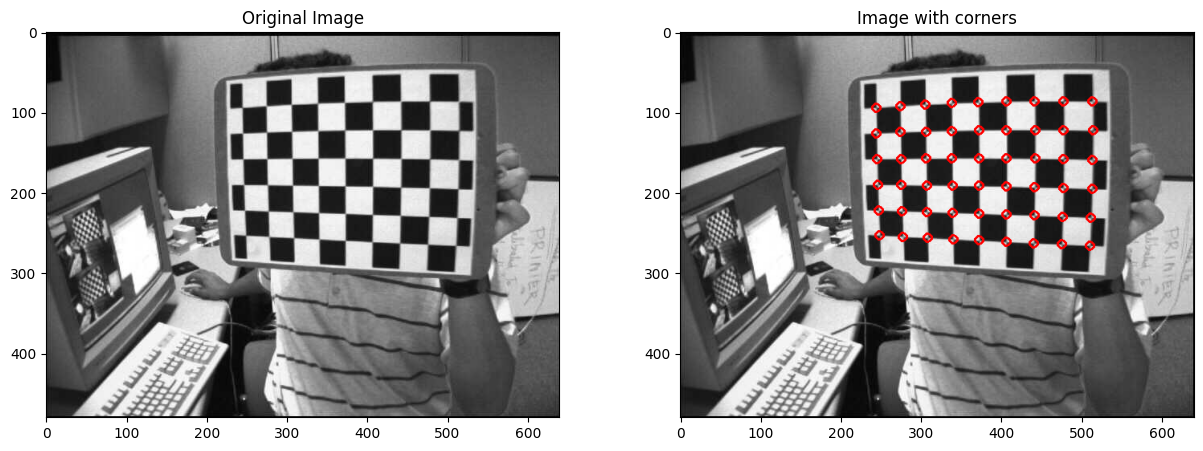

In [ ]:
img2 = np.copy(img)  # Make a copy of original img as img2

# Add circles to img2 at each corner identified
for corner in corners:
    coord = (int(corner[0]), int(corner[1]))
    cv2.circle(img=img2, center=coord, radius=5, color=(0, 0,  255), thickness=2)

plot_side_by_side(img, img2, title2="Image with corners")

* Use [`cornerSubPix`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e) function to refine the corners extracted to sub-pixel accuracy.
> When calibrating a camera, you typically detect corners on a calibration pattern, such as a chessboard or a grid of dots. However, due to factors like noise and interpolation in the image, the detected corner coordinates might not be perfectly accurate.

* Then examine how much the corners have shifted in pixels.

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # Set termination criteria as a tuple.

# termination criteria that we're going to use when we are finding the subpixels in our images, to find corners

# OpenCV provides termination criteria for iterative algorithms, and in this case, it's using a combination of two criteria:
# cv2.TERM_CRITERIA_EPS and cv2.TERM_CRITERIA_MAX_ITER. The third argument 30 specifies the maximum number of iterations,
# and the last argument 0.001 specifies the epsilon value, which determines the required accuracy.


corners_orig = corners.copy()  # Preserve the original corners for comparison after
corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=criteria) # extract refined corner coordinates.

In [ ]:
shift = corners - corners_orig

print(shift[:4,:])
print(np.linalg.norm(shift.reshape(-1,1), np.inf))

[[-0.0488739  -0.19455719]
 [-0.22705078 -0.03068542]
 [ 0.0071106  -0.08568573]
 [-0.05487061 -0.04328918]]
0.38919067


* Generate a figure to compare the original corners to the corrected corners.



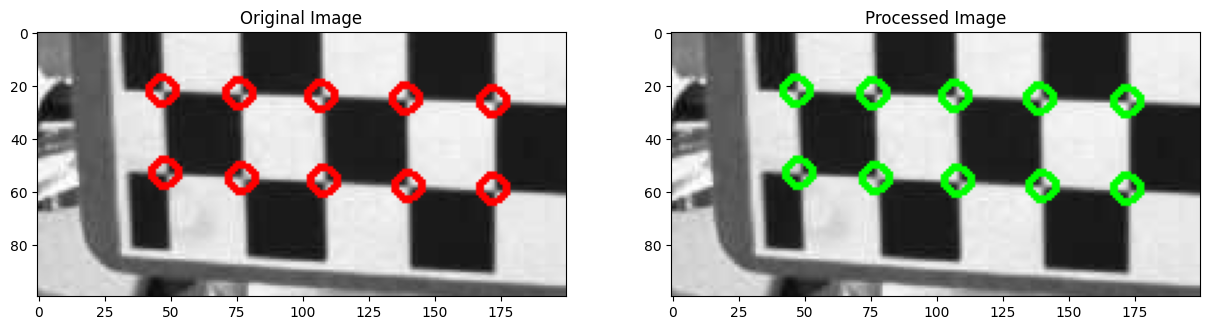

In [ ]:
img3 = np.copy(img)

for corner in corners:
    coord = (int(corner[0]), int(corner[1]))
    cv2.circle(img=img3, center=coord, radius=5, color=(0, 255, 0), thickness=2)

plot_side_by_side(img2[200:300,200:400,:], img3[200:300,200:400,:])

* Use [`drawChessboardCorners`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022) function to visualize the corners detected on the chessboard pattern in the image.

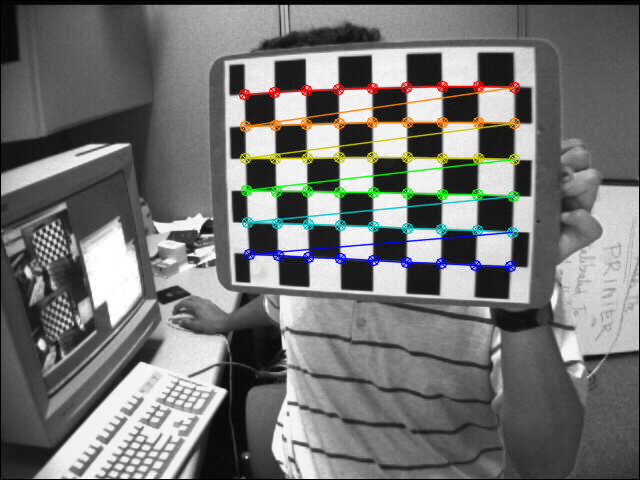

In [ ]:
img4 = cv2.drawChessboardCorners(img, (9, 6), corners, retval)

cv2_imshow(img4)

* Repeat the previous processes with all the chessboard images to remove distortion effects.
> * First, assume a 3D world coordinate system aligned with the chessboard.

In [ ]:
obj_grid = np.zeros((9*6,3), np.float32) # 54 rows and 3 columns. Each row represents a 3D point in space, and each point has three coordinates (x, y, z)
obj_grid[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # populate the first two columns of obj_grid with the x and y coordinates of the grid points

print(obj_grid)

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [7. 1. 0.]
 [8. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [7. 2. 0.]
 [8. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [7. 3. 0.]
 [8. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [7. 4. 0.]
 [8. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]
 [8. 5. 0.]]


* Then create two arrays:
    * to store 3d world coordinates
    * to store 2d image coordinates

In [ ]:
obj_points = [] # 3d world coordinates - for the object points we get during camera calibration
img_points = [] # 2d image coordinates
# we actually have a relation between 2d and 3d by having this camera matrix

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    img = cv2.imread(f"chessboard_imgs/{fname}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    retval, corners = cv2.findChessboardCorners(gray, (9,6)) # find the chessboard corners

    if retval: # if found
        obj_points.append(obj_grid) # add object points

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria) # refine the image points
        # to find the corners in the subpixels of the image

        img_points.append(corners2) # add image points

* The accumulated lists of object coordinates and image coordinates can be combined to determine an optimal set of camera calibration parameters. Use [`calibrateCamera`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) to determine the parameters.

In [ ]:
retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

In [ ]:
print(retval) # Objective function value
print("\n")
print(mtx)    # Camera matrix
print("\n")
print(dist)   # Distortion coefficients

0.4086955848818596


[[536.07343019   0.         342.3703879 ]
 [  0.         536.01634475 235.53685636]
 [  0.           0.           1.        ]]


[[-0.26509006 -0.0467439   0.00183301 -0.00031471  0.25231586]]


* Use [`getOptimalNewCameraMatrix`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga7a6c4e032c97f03ba747966e6ad862b1) function to construct a new camera matrix appropriate for the image `left12.jpg`.
* Then use [`undistort`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d) to remove distortion effects.

In [ ]:
img = cv2.imread('chessboard_imgs/left12.jpg')

h,w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

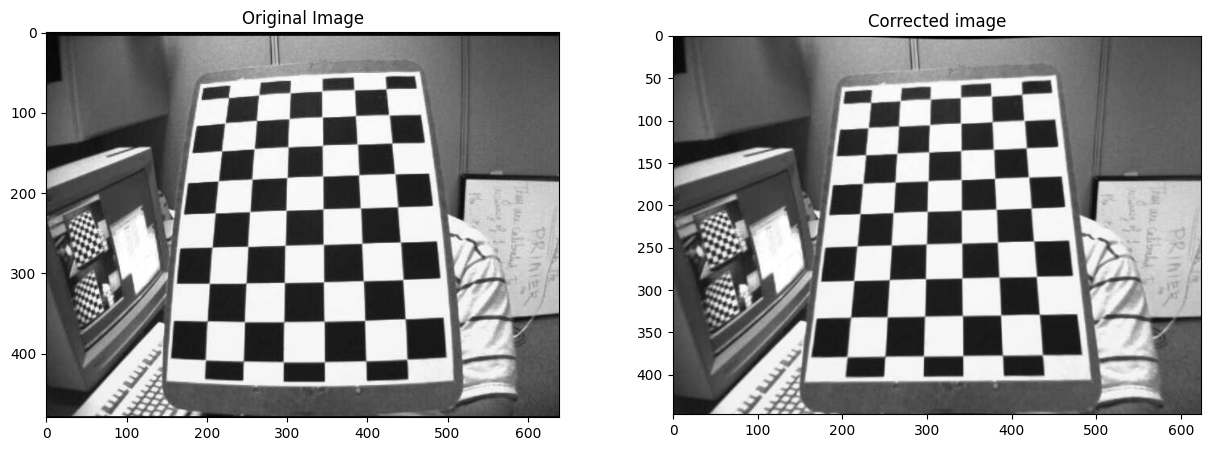

In [ ]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

plot_side_by_side(img, dst, title2="Corrected image")

* Now try to use undistort with remapping (with [`initUndistortRectifyMap`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga7dfb72c9cf9780a347fbe3d1c47e5d5a) function) to see the differences in the output.
> The function computes the joint undistortion and rectification transformation and represents the result in the form of maps for remap.
>
> We will get two maps for x and y directions. Then we need to use [`remap`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4) function to get the undistorted image.

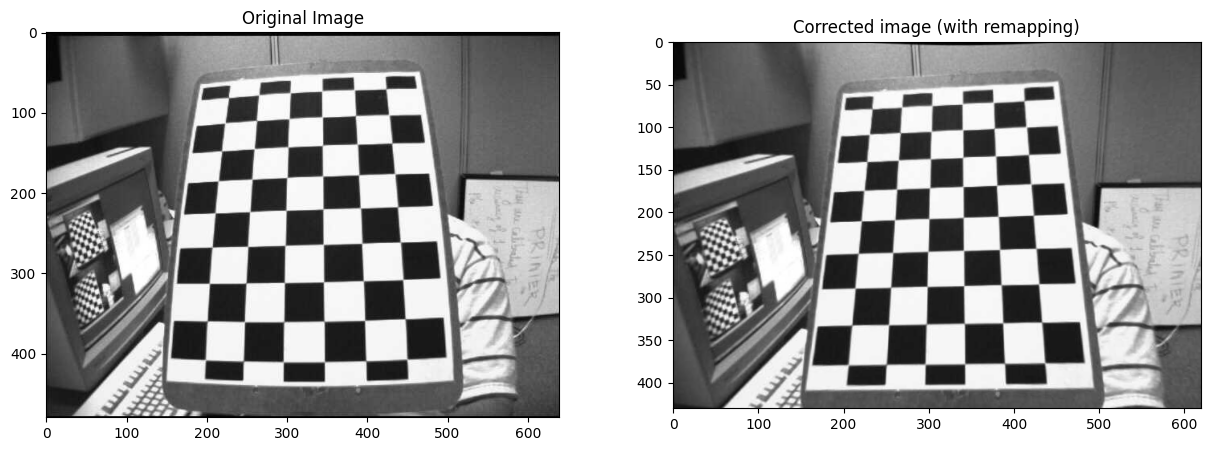

In [ ]:
# undistort
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), 5)
dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

plot_side_by_side(img, dst, title2="Corrected image (with remapping)")

* Calculate the reprojection error. Use [`projectPoints`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c) to project 3D points in the world coordinate system onto the 2D image plane.

> Reprojection error is a calculation of difference between "*points detected from image*" and "*points reprojected using camera parameters*".

> For the camera calibration parameters, take the original projection formula, recalculate the new image pixel values projected from the 3D world coordinate system to the 2D image plane coordinate system, and then calculate the reprojection error.

In [ ]:
mean_error = 0

for i in range(len(obj_points)):
    img_points2, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(img_points[i], img_points2, cv2.NORM_L2)/len(img_points2)
    mean_error += error

print( "total error (mean absolute error): {}".format(mean_error/len(obj_points)) )

total error (mean absolute error): 0.04095728538983061
